# Project Setup

## Imports

In [1]:
# import librosa
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
import skl2onnx

sys.path.append(os.getcwd())

import python_utils

## Global Variables

In [2]:
PREPROCESSED_DATA_TO_USE = "preprocessed_data_2025-03-05 15:15:03.477584.pkl"
TRAINED_MODELS_DIR = "trained_models"
TRAIN_PROPORTION = 0.66
RANDOM_SEED = 42
WINDOW_SIZE = 6616 # From preprocessing.ipynb

In [3]:
np.random.seed(RANDOM_SEED)

# Load Data

In [4]:
import pickle

with open(os.path.join("data", "preprocessed_data", PREPROCESSED_DATA_TO_USE), 'rb') as file:
    tracker = pickle.load(file)

print(tracker.keys())
python_utils.custom_print(tracker)

dict_keys(['PXL_20250222_012947893.TS', 'PXL_20250223_164250127.TS', 'PXL_20250223_164224211.TS', 'PXL_20250223_164321190.TS', 'PXL_20250222_013140200.TS'])
{
  'PXL_20250222_012947893.TS': {
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.3242560e-04,  7.0753385e-04,  7.3038030e-04],
       [ 6.8282022e-04,  6.7373691e-04,  4.2436406e-04, ...,
         1.0909824e-04,  1.5050969e-03,  2.6611104e-03],
       [ 3.4842943e-03,  3.9587440e-03,  4.0320847e-03, ...,
        -4.6930549e-04, -8.7165259e-05,  2.9021440e-04],
       ...,
       [ 6.7755431e-03,  7.1415151e-03,  7.5735068e-03, ...,
        -1.2880318e-02, -1.3739228e-02, -1.3548862e-02],
       [-1.1642830e-02, -9.9556111e-03, -8.7874476e-03, ...,
         4.5384052e-03,  5.7235630e-03,  7.7298535e-03],
       [ 8.6277872e-03,  7.5738011e-03,  4.9800808e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
    'y': array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,

# Preprocess
* Audio data are transformed into decible spectograms (2D arrays)

In [5]:
# def transform_audio(audio_values: np.array, window_size: int, top_db: float = 75.0) -> np.array:
#     """Transform audio values into a magnitude spectrogram in decibels,
#        ensuring the output has the same number of time frames as the input.
#     """
#     audio_stft = librosa.stft(
#         y=audio_values,
#         n_fft=window_size,
#         hop_length=window_size // 2, # Ensure overlap to match input length
#     )
#     audio_abs = np.abs(audio_stft)
#     audio_db = librosa.amplitude_to_db(audio_abs, top_db=top_db)

#     return audio_db

In [6]:
# for base_name in tracker:
#   # Transform raw data into spectogram
#   tracker[base_name]["audio_spectogram"] = transform_audio(
#       audio_values=tracker[base_name]["audio_values"],
#       window_size=WINDOW_SIZE,
#   )


# custom_print(tracker)

In [7]:
# # Plot the transformed audio data
# fig, ax = plt.subplots(figsize=(10, 5))
# img = librosa.display.specshow(tracker[base_name]["audio_spectogram"],
#                               x_axis='time',
#                               y_axis='log',
#                               ax=ax)
# ax.set_title('Spectogram Example', fontsize=20)
# fig.colorbar(img, ax=ax, format=f'%0.2f')
# plt.show()

# Train, Test Split
Split on datafile; use data for testing that is in files that were not used for training.

In [8]:
files_list = list(tracker.keys())
np.random.shuffle(files_list)
train_files = files_list[:int(round(TRAIN_PROPORTION * len(files_list)))]
test_files = files_list[int(round(TRAIN_PROPORTION * len(files_list))):]

train_test = {
    "train": {
        "files": train_files,
        "x": list(),
        "y": list(),
    },
    "test": {
        "files": test_files,
        "x": list(),
        "y": list(),
    },
}

for base_name in files_list:
  for i in range(len(tracker[base_name]["x"])):
    if base_name in train_test["train"]["files"]:
      train_test["train"]["x"].append(tracker[base_name]["x"][i])
      train_test["train"]["y"].append(tracker[base_name]["y"][i])
    else:
      train_test["test"]["x"].append(tracker[base_name]["x"][i])
      train_test["test"]["y"].append(tracker[base_name]["y"][i])

for train_or_test in train_test:
  for x_or_y in ["x", "y"]:
    train_test[train_or_test][x_or_y] = np.array(train_test[train_or_test][x_or_y])

python_utils.custom_print(train_test)

{
  'train': {
    'files': ['PXL_20250223_164250127.TS', 'PXL_20250222_013140200.TS', 'PXL_20250223_164224211.TS']
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.7100417e-04,  6.2051247e-04,  6.6931831e-04],
       [ 6.8210997e-04,  9.3359139e-04,  1.6390178e-03, ...,
        -3.2750266e-03, -4.5028119e-03, -3.9297910e-03],
       [-3.5020267e-03, -3.4659980e-03, -3.8957985e-03, ...,
        -2.9480169e-03, -2.2197529e-03, -4.0944768e-03],
       ...,
       [ 2.2600004e-03,  2.5268346e-03, -4.9848924e-04, ...,
         5.2970140e-03,  6.8075233e-03,  8.2097165e-03],
       [ 8.6583141e-03,  9.3627395e-03,  9.1678835e-03, ...,
         6.1468716e-05,  6.0503697e-04,  2.2371202e-03],
       [ 3.6902158e-03,  4.9239211e-03,  6.6524446e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
    'y': array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,

# Train Model

In [9]:
models = dict()

## Suport Vector Machine

In [10]:
models["SVM"] = dict()
models["SVM"]["model"] = svm.SVC()
models["SVM"]["model"].fit(train_test["train"]["x"], train_test["train"]["y"])
models["SVM"]["y_pred"] = models["SVM"]["model"].predict(train_test["test"]["x"])
models["SVM"]["accuracy"] = metrics.accuracy_score(
    train_test["test"]["y"],
    models["SVM"]["y_pred"],
)

# Evaluate Models

## Accuracy

In [11]:
for model in models:
  print(f"{model}: {models[model]['accuracy']}")

SVM: 0.7459016393442623


## Visualize Predictions

In [12]:
NUM_VISUALIZATIONS = 10

In [13]:
def plot_examples(x_test, y_test, models, indices_to_plot, num_visualizations, ylim = 0.5):
  num_plots = min(len(indices_to_plot), num_visualizations)
  fig, ax = plt.subplots(
      figsize=(10, 30),
      nrows=num_plots,
      ncols=1,
  )
  for i in range(num_plots):
    pd.Series(x_test[indices_to_plot[i]]).plot(
        lw=1,
        color='blue',
        ax=ax[i],
        label=f"Actual: {y_test[indices_to_plot[i]]}, Predictions: " + str([f"{model}: {models[model]['y_pred'][indices_to_plot[i]]}" for model in models]),
    )
    ax[i].legend()
    ax[i].set_ylim(-ylim, ylim)
  plt.show()

## Random Sample

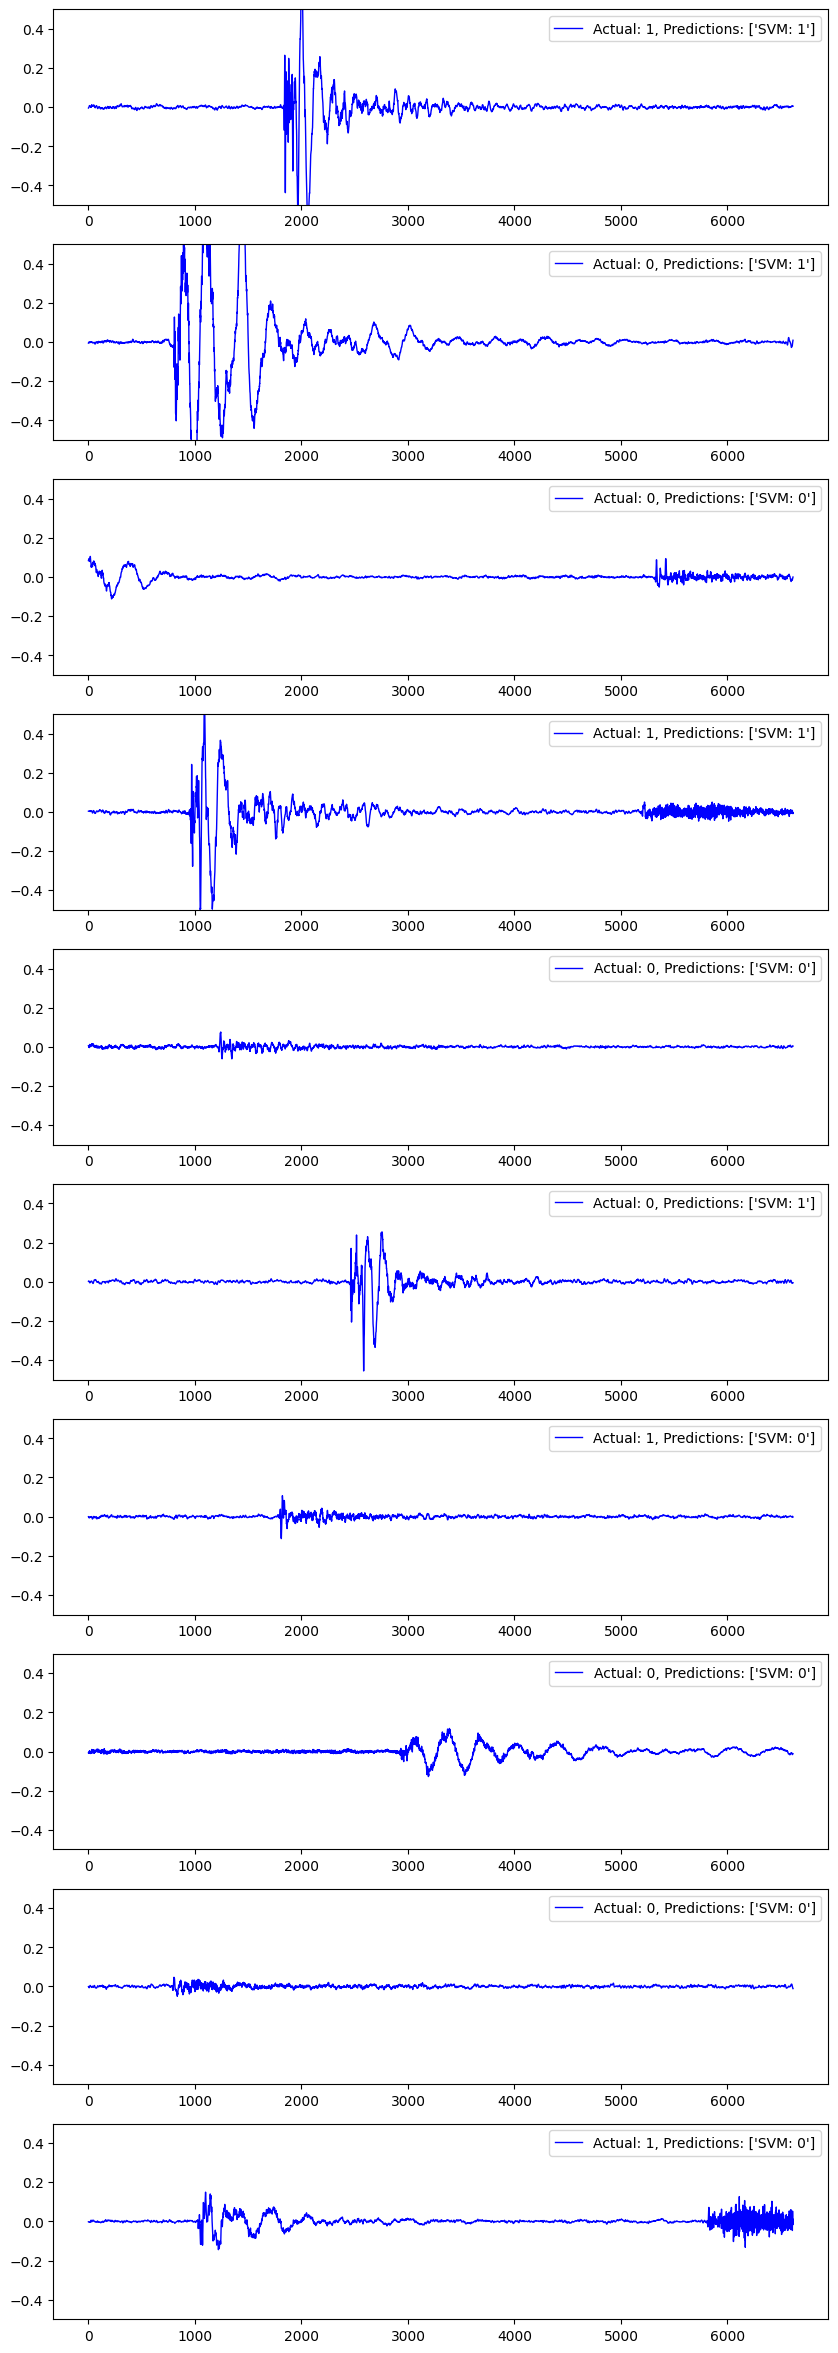

In [14]:
random_indices = np.random.choice(
    train_test["test"]["x"].shape[0],
    NUM_VISUALIZATIONS,
    replace=False,
    )

plot_examples(
    x_test=train_test["test"]["x"],
    y_test=train_test["test"]["y"],
    models=models,
    indices_to_plot=random_indices,
    num_visualizations=NUM_VISUALIZATIONS,
)

## Incorrect Predictions

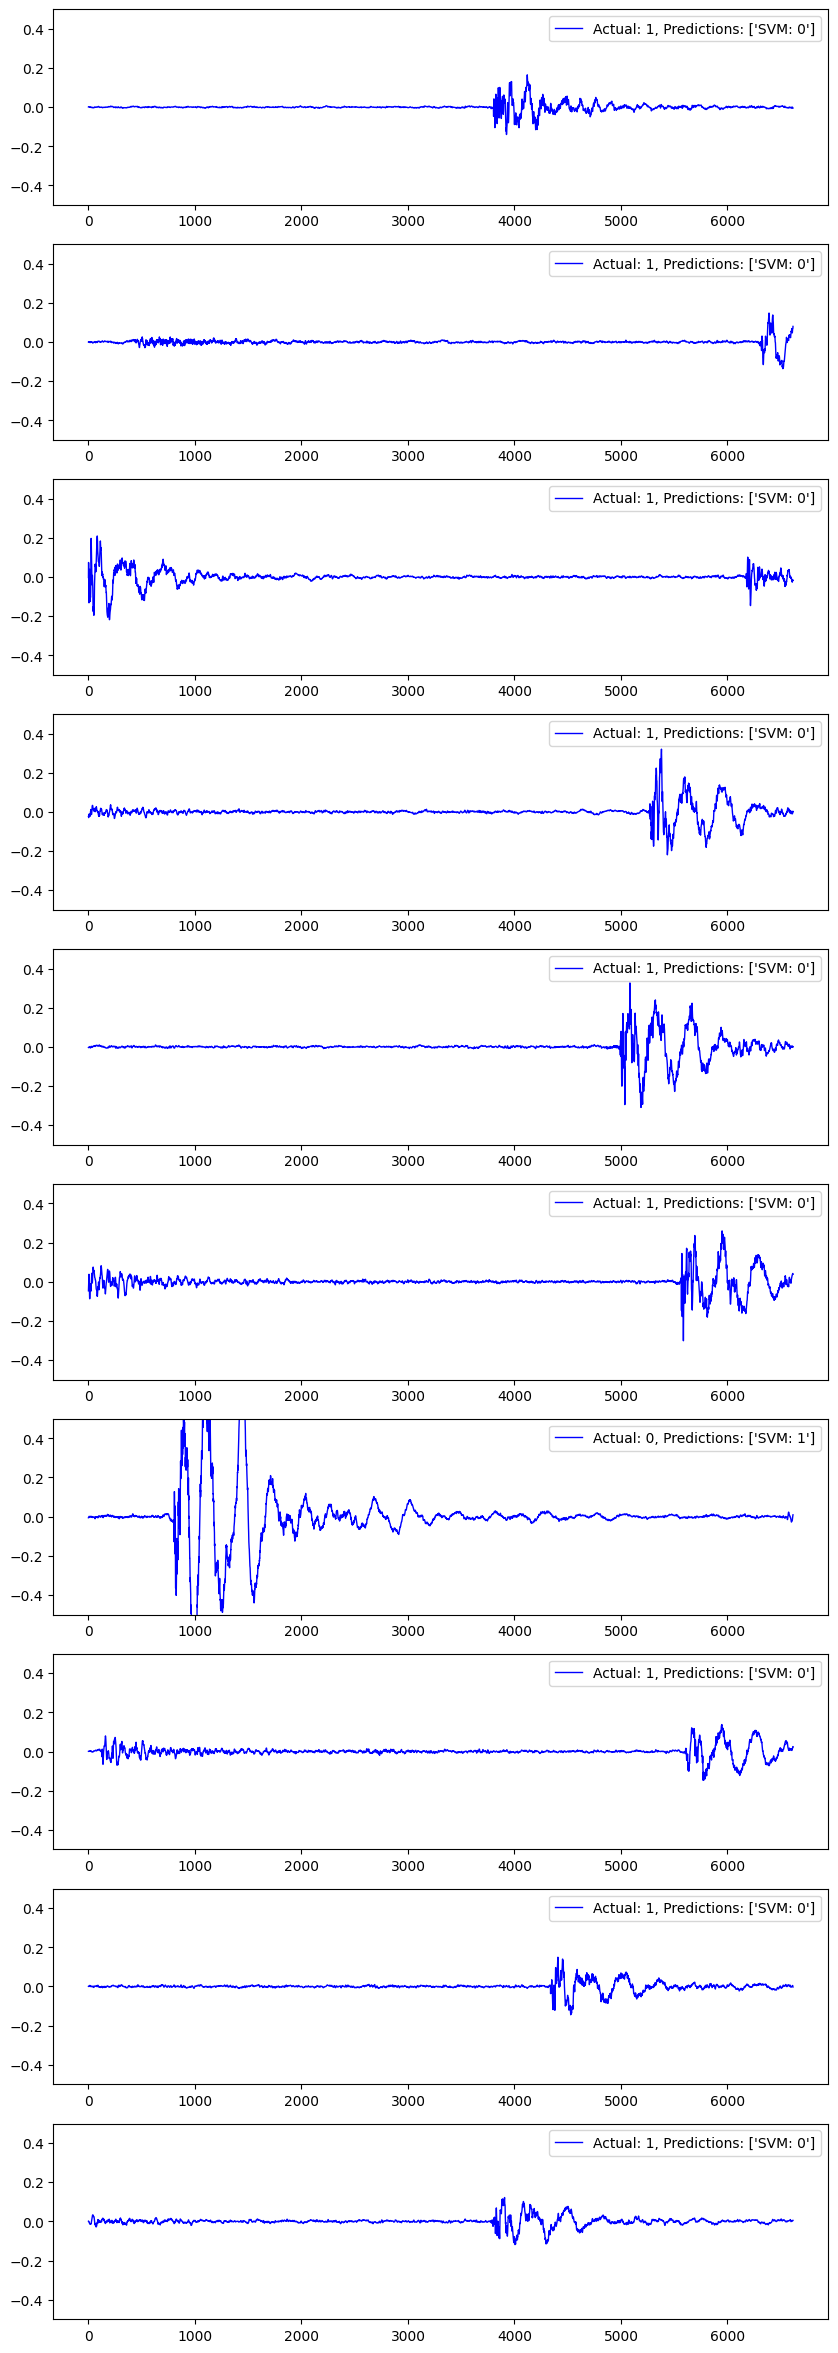

In [15]:
for model in models:
  models[model]["incorrect_indices"] = np.where(train_test["test"]["y"] != models[model]["y_pred"])[0]

plot_examples(
    x_test=train_test["test"]["x"],
    y_test=train_test["test"]["y"],
    models=models,
    indices_to_plot=models["SVM"]["incorrect_indices"],
    num_visualizations=NUM_VISUALIZATIONS,
)

# Save Models for Deployment

In [16]:
# Convert the model to ONNX
initial_type = [('float_input', skl2onnx.common.data_types.FloatTensorType([None, train_test["train"]["x"][0].shape[0]])) ] #Replace X.shape[1] with the correct shape.
onnx_model = skl2onnx.convert_sklearn(models["SVM"]["model"], initial_types=initial_type)

# Save the ONNX model
with open(os.path.join(TRAINED_MODELS_DIR, f'model_svm_{pd.Timestamp.now()}.onnx'), 'wb') as f:
    f.write(onnx_model.SerializeToString())